# Лабараторная работа №4:  Векторное представление текста и его кластерный анализ

---

# Задание:
1. Дана коллекция текстовых документов `2021_SPORT`
2. Необходимо провести их кластерный анализ методом спектральной кластеризации и визуализировать кластеры
    1. Вам понадобится NLTK, PyMorphy 3 для обработки ЕЯ, Scikit-Learn, SciPy, NumPy, опционально pandas для кластеризации, matplotlib и seaborn для визуализации
    2. Для этого каждый текст необходимо предварительно обработать: токенизировать (изучите `nltk.tokenize`), удалить стоп-слова (`nltk.corpus`, нормализовать (лемматизировать) (`pymorphy3`).
    3. Затем из обработанных текстов нужно составить корпус — коллекцию документов в нормальной форме
    4. Корпус передается в качестве аргумента в векторизатор (см. [`CountVectorizer` в Scikit-Learn](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage), пока считайте только униграммы, максимум признаков — 100-150, можно экспериментировать)
    5. Затем нужно построить матрицу расстояний (`squareform`, `pdist` из SciPy), для текстов чаще всего берут косинусное расстояние (`cosine`) и визуализировать ее в виде тепловой карты (Seaborn вам в помощь)
    6. Далее кластеризуем, проверяем коэффициент силуэта — может оказаться, что лучше покажет себя такая настройка: `SpectralClustering(affinity='precomputed', random_state=0`, в этом случае нужно матрицу расстояний перевести в матрицу сходства через формулу: `similarity_matrix = np.exp(- matrix ** 2 / (2. * delta ** 2))`, где `delta` — ширина Гауссова ядра, рекомендую начать где-то с 4.0
    7. Визуализируем полученные кластеры

---

1. Установка и импорт библиотек: NLTK, PyMorphy 3 для обработки ЕЯ, Scikit-Learn, SciPy, NumPy, опционально pandas для кластеризации, matplotlib и seaborn для визуализации

In [24]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

import os
from dataclasses import dataclass, field                                
from typing import List

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
@dataclass   
class Folders: 
    files_name: List[str] = field(default_factory=list)
    data: List[str] = field(default_factory=list)

@dataclass 
class Home:
    path: str = ''
    name: str = ''
    folders_name: List[Folders] = field(default_factory=list)


2. Токинезация, удаление стоп-слов, нормализация (лемматизация)

In [5]:
# Этот код загрузит необходимые данные punkt, которые используются для токенизации текста
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
morph = pymorphy3.MorphAnalyzer()

[nltk_data] Downloading package punkt to /home/kirill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kirill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Составление корпуса — коллекции документов в нормальной форме

In [23]:
home = Home()
folders = Folders()
corpus = []
path_to_file_list = []
home.path = '/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4/'
home.name = '2021_SPORT'
folders_list = os.listdir(home.path + '/' + home.name)

for i in folders_list:
    home.folders_name.append(i)
    d = os.listdir(home.path + '/' + home.name + '/' + i) 
    folders.files_name.append(d)
    
    for el in folders.files_name:
        for j in el:
            path_to_file_list.append(home.path + '/' + home.name + '/' + i  + '/' + j)
   
for i in path_to_file_list:
    with open(i, 'r', encoding='utf-8') as f:
        text = f.read()
        tokens = word_tokenize(text)
        tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and not token.isdigit()]
        tokens = [token for token in tokens if token not in stop_words]
        text = ' '.join(tokens)
        corpus.append(text)

 


/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/77.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/7.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/11.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/39.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/12.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structured-data/Methods-and-algorithms-for-weakly-structured-data/lab4//2021_SPORT/Локомотив/23.txt
/home/kirill/projects/Methods-and-algorithms-for-weakly-structure

"    with open(path_to_file, 'r', encoding='utf-8') as f:\n        text = f.read()\n        tokens = word_tokenize(text)\n        tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and not token.isdigit()]\n        tokens = [token for token in tokens if token not in stop_words]\n        text = ' '.join(tokens)\n        corpus.append(text)"

In [6]:
vectorizer = CountVectorizer(max_features=150)
X = vectorizer.fit_transform(corpus).toarray()

In [7]:
distance_matrix = squareform(pdist(X, metric='cosine'))

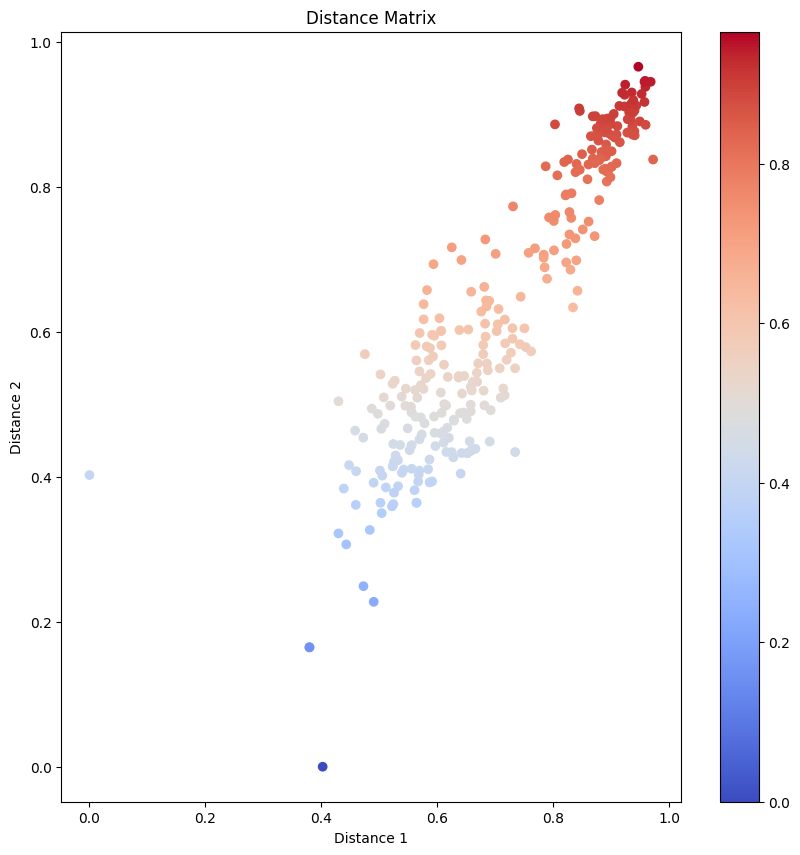

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(distance_matrix[:,0], distance_matrix[:,1], c=distance_matrix[:,1], cmap='coolwarm', marker='o')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Distance 1')
plt.ylabel('Distance 2')
plt.show()

In [9]:
similarity_matrix = np.exp(-distance_matrix ** 2 / (2. * 4.0 ** 2))  # Преобразуем матрицу расстояний в матрицу сходства
spectral = SpectralClustering(affinity='precomputed', random_state=0, n_clusters=3)
clusters = spectral.fit_predict(similarity_matrix)


In [10]:
silhouette_avg = silhouette_score(similarity_matrix, clusters)
print("Average silhouette score:", silhouette_avg)

Average silhouette score: 0.35161929121096225


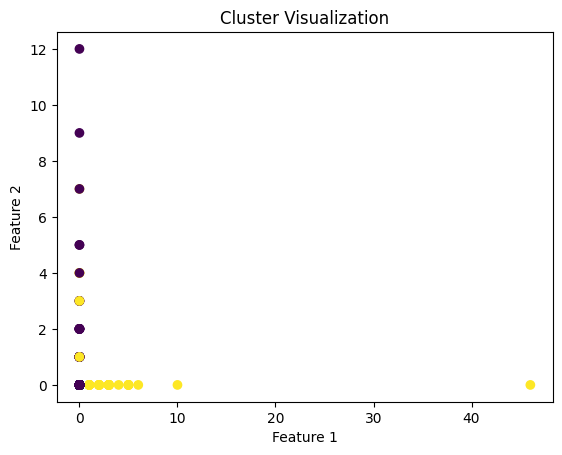

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()